In [22]:
# Load Necessary Packages

%load_ext autoreload
%autoreload 2

import os
import holoviews as hv
from holoviews import renderer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import easygui
import pandas as pd
import glob
from src.fiberphotometry import ImportTDTData
from src.fiberphotometry import Channels
from src.video import UsbVideo, Params4Motion
import src.FreezeAnalysis as fz
from src.plotting import FP_Plotting

Plotter = FP_Plotting()


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#### The any functions that should be altered are "sessIdx" and "SHOCK_DELAY"

# Set path to folder that contains all the sessions
Data_path = []

if not Data_path:
    Data_path = easygui.diropenbox()

# change directory to the data path
os.chdir(Data_path)

list_of_SessFolders = os.listdir(Data_path)

# filter out any ini files
list_of_SessFolders = [f for f in list_of_SessFolders if not f.endswith('.ini')]
list_of_SessFolders.sort()

print("Available sessions:")
for idx, sessFolder in enumerate(list_of_SessFolders):
    print(f"|-- {idx}: {sessFolder}")

#### Running this cell will open a window somewhere, set directory to Test_Data, and come back here to modify which session you want by setting sessIDX
sessIdx = 3

curr_sessFolder = os.path.abspath(list_of_SessFolders[sessIdx])

print(f"User selected session: {curr_sessFolder}")

# change directory to the session folder
os.chdir(curr_sessFolder)

video_file = glob.glob('*.avi')[0]

print(f"Found video file: {video_file}")

if "A" in curr_sessFolder:
    cxt_idx = 0
elif "B" in curr_sessFolder:
    cxt_idx = 1
elif "C" in curr_sessFolder:
    cxt_idx = 2
else:
    raise ValueError(f"Unknown context: {curr_sessFolder}")

Available sessions:
|-- 0: data_cleanup.xlsx
|-- 1: data_cleanup_parsed.xlsx
|-- 2: data_cleanup_parsed_good.xlsx
|-- 3: nia_02_5HT_cxtA_day_1
|-- 4: nia_02_5HT_cxtA_day_2
|-- 5: nia_02_5HT_cxtA_day_3
|-- 6: nia_02_5HT_cxtB_day_2
|-- 7: nia_02_5HT_cxtB_day_3
|-- 8: nia_02_5HT_cxtC_day_4
|-- 9: nia_04_5HT_cxtA_day_1
|-- 10: nia_04_5HT_cxtA_day_2
|-- 11: nia_04_5HT_cxtA_day_3
|-- 12: nia_04_5HT_cxtB_day_2
|-- 13: nia_04_5HT_cxtB_day_3
|-- 14: nia_04_5HT_cxtC_day_4
|-- 15: nia_06_5HT_cxtA_day_1
|-- 16: nia_06_5HT_cxtA_day_2
|-- 17: nia_06_5HT_cxtA_day_3
|-- 18: nia_06_5HT_cxtB_day_2
|-- 19: nia_06_5HT_cxtB_day_3
|-- 20: nia_06_5HT_cxtC_day_4
|-- 21: nia_08_5HT_cxtA_day_1
|-- 22: nia_08_5HT_cxtA_day_2
|-- 23: nia_08_5HT_cxtA_day_3
|-- 24: nia_08_5HT_cxtB_day_2
|-- 25: nia_08_5HT_cxtB_day_3
|-- 26: nia_08_5HT_cxtC_day_4
|-- 27: nia_10_5HT_cxtA_day_1
|-- 28: nia_10_5HT_cxtA_day_2
|-- 29: nia_10_5HT_cxtA_day_3
|-- 30: nia_10_5HT_cxtB_day_2
|-- 31: nia_10_5HT_cxtB_day_3
|-- 32: nia_10_5HT_cxtC

In [5]:
# Read Fiber Photometry Data
TDTDATACLASS = ImportTDTData(curr_sessFolder)
data = TDTDATACLASS.data

# Deletes first TTL pulse if there are more than 3 pulses in the array
data.epocs.PtC0.onset = fz.delete_first_ttl(data.epocs.PtC0.onset)

Found Synapse note file: C:\Users\khansha\Test_Data\nia_02_5HT_cxtA_day_1\Notes.txt
read from t=0s to t=260.53s


In [6]:
# Processing the EZTracker Motion Data
# Set time for before and after shock

seconds4cue = 30
video = UsbVideo(video_file, seconds4Cue=seconds4cue)
video_params = video.video_params
video_dict = video.video_create4FreezeAnalysis

behavior_fps = video_params['fps']
total_behavior_frames = video_params['frame_count']

# TODO ADD THIS TO SRC.UsbVideo to remove redundacy
preCue_onset = None
postCue_onset = None
frame_window = seconds4cue * behavior_fps
#preCue_onset = frame_window - SHOCK_DELAY
#postCue_onset = frame_window + SHOCK_DELAY

if preCue_onset is not None and postCue_onset is not None:
    video = UsbVideo(video_file, preCue_onset=preCue_onset, postCue_onset=postCue_onset)
    video_params = video.video_params
    video_dict = video.video_create4FreezeAnalysis

# Convert fiber time and TTL pulses to match behavior video frames
final_frame = ((data.info.duration.total_seconds()) * behavior_fps) # final frame of fiber recording
pulses = tuple(final_frame - (onset * behavior_fps) for onset in data.epocs.PtC0.onset)


# Here we are adjusting the start/end of the behavior data to match the fiber data. 
# This will be based on the second/shock pulse -> looking at x frames / x/fps sec before and after

frames_before_shock = video.preCue_onset
frames_after_shock = video.postCue_onset

# Here we input the frame at which the mouse is shocked, which is manually located in the behavioral video

#### Modify shock delay using value in the txt file
SHOCK_DELAY = 47

video_dict['start'] = int(total_behavior_frames - (int(pulses[1]) + frames_before_shock - SHOCK_DELAY))
video_dict['end'] = int(total_behavior_frames - (int(pulses[1]) - frames_after_shock - SHOCK_DELAY))

In [7]:
print (f"Pulse times (s): {data.epocs.PtC0.onset}")
print (f"Total session duration (s): {data.info.duration.total_seconds()}")
print (f"FPS: {behavior_fps}")
print (f"Total frames found in behavior video: {total_behavior_frames}")
print (f"Final frame (fiber recording): {final_frame}")
print (f"Frames before shock: {frames_before_shock}")
print (f"Frames after shock: {frames_after_shock}")
for idx, pulse in enumerate(pulses):
    print (f"Pulse {idx} (from final frame): {pulse}")
print (f"Shock Delay (frames): {SHOCK_DELAY}")

Pulse times (s): [  7.45275392 188.80151552 250.9217792 ]
Total session duration (s): 260.527941
FPS: 20.0
Total frames found in behavior video: 5209.0
Final frame (fiber recording): 5210.55882
Frames before shock: 600
Frames after shock: 600
Pulse 0 (from final frame): 5061.5037416000005
Pulse 1 (from final frame): 1434.5285095999998
Pulse 2 (from final frame): 192.12323600000036
Shock Delay (frames): 47


In [8]:
# %%output size=output_size4console
# Load Freezing Video and Crop Frame if Desired

img_crp, video_dict = fz.LoadAndCrop(video_dict, cropmethod="Box")

file: .\pattern-240604-113630_nia_2-240611-152723_Cam1.avi
total frames: 5209
nominal fps: 20.0
dimensions (h x w): 480,640


In [9]:
# Set Motion Threshold for behavior Video
mt_cutoff = Params4Motion.MT_CUTOFF.value[cxt_idx]

# Detect Motion

h, w = Params4Motion.HEIGHT_WIDTH.value

In [10]:

Motion = fz.Measure_Motion(video_dict, mt_cutoff, SIGMA=Params4Motion.SIGMA.value) # x-axis
Motion_frameArr = np.arange(len(Motion)) # y-axis

100%|█████████████████████████████████████████████████████████████████████████████| 1199/1199 [00:06<00:00, 183.31it/s]


total frames processed: 1200



In [11]:
ShockTime4Beh_noDelay = Params4Motion.SHOCKTIME.value
ShockTime4Beh_wDelay = ShockTime4Beh_noDelay
ShockTime4Fiber = ShockTime4Beh_noDelay

# Calculate offset based on time_before_shock
offset = ShockTime4Beh_noDelay - (frames_before_shock / behavior_fps)

# Convert frame numbers to seconds and offset to match original timing
# time_in_seconds = (Motion_frameArr / behavior_fps) + offset
Motion_frameArr_TimeStamps = (Motion_frameArr / behavior_fps) + offset

# X axis data to use for plotting
# represents time before/after shock
Motion_frameArr_TS_Onset = Motion_frameArr_TimeStamps - ShockTime4Beh_wDelay
xLims = (-seconds4cue, seconds4cue)

# Plot Motion Graph
plt_mt = hv.Curve((Motion_frameArr_TS_Onset, Motion), 'Time from shock (s)', 'Pixel Change', label='Motion').opts(
    height=h, width=w, line_width=1, color="steelblue",
    title="Motion Across Session", padding=0.0, show_grid=False, xlim=xLims)

# Convert shock line position to seconds (always at 180s)
shock_line = hv.VLine(0, label='Shock Time').opts(
    color='red', line_dash='dashed')


In [12]:
from src.video import Params4Motion

FreezeThresh = Params4Motion.FREEZE_THRESH.value[cxt_idx]
MinDuration = Params4Motion.MIN_DURATION.value
print(f"FreezeThresh: {FreezeThresh}")
print(f"MinDuration: {MinDuration}")

Freezing = fz.Measure_Freezing(Motion, FreezeThresh, MinDuration)  
print(f'Average Freezing: {np.average(Freezing)}%')

# Create freezing area plot with adjusted time axis
# TODO FIND WAY TO ADD XLIMS TO HOLOVIEW
plt_fz = hv.Area((Motion_frameArr_TS_Onset, Freezing*(Motion.max()/100)), 'Time from shock (s)', 'Motion').opts(
    color='lightgray',line_width=0,line_alpha=0)
plt_mt = hv.Curve((Motion_frameArr_TS_Onset, Motion), 'Time from shock onset (s)', 'Motion').opts(
    height=h, width=w, line_width=1, color='steelblue', xlim=xLims,
    title="Motion Across Session with Freezing Highlighted in Gray")
threshold_line = hv.HLine(y=FreezeThresh).opts(
    color='red', line_width=1, line_dash='dashed')
(plt_fz * plt_mt * threshold_line * shock_line).opts(
    padding=0.0,margin=0,show_grid=False)

FreezeThresh: 3500
MinDuration: 20
Average Freezing: 0.0%


:Overlay
   .Area.I           :Area   [Time from shock (s)]   (Motion)
   .Curve.I          :Curve   [Time from shock onset (s)]   (Motion)
   .HLine.I          :HLine   [x,y]
   .VLine.Shock_Time :VLine   [x,y]

In [23]:
# Now processing fiber neural data
# Make a time array based on the number of samples and sample freq
matplotlib.rcParams['font.size'] = 18

Serotonin = Channels.DYNAMIC.value    # Serotonin channel
ISOS = Channels.ISOS.value  # Isosbestic channel
sampling_rate = data.streams[Serotonin].fs
sample_count = len(data.streams[Serotonin].data)
fiber_time = np.linspace(1, sample_count, sample_count)/sampling_rate

# Calculate offset to make shock appear at 180s
fiber_offset = Params4Motion.SHOCKTIME.value - data.epocs.PtC0.onset[1] 
fiber_time_offset = fiber_time + fiber_offset

# shock time now will be 0
fiber_time2use = fiber_time_offset - ShockTime4Fiber

In [24]:
# Artifact Removal with adjusted time window
t = 8
inds = np.where(fiber_time>t)
ind = inds[0][0]
fiber_time_AR = fiber_time[ind:]
fiber_time_offset_AR = fiber_time_AR + fiber_offset  # Recalculate offset time after artifact removal
fiber_time2use_AR = fiber_time_offset_AR - ShockTime4Fiber
Serotonin_AR = data.streams[Serotonin].data[ind:]
ISOS_AR = data.streams[ISOS].data[ind:]

In [25]:
def find_binned_avg(signal, N):
    binned_avg = [] 
    for i in range(0, len(signal), N):
        binned_avg.append(np.mean(signal[i:i+N-1]))
    return np.array(binned_avg)


# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value

binned_avg_Serotonin_AR = find_binned_avg(Serotonin_AR, N)
binned_avg_ISOS_AR = find_binned_avg(ISOS_AR, N)

# given the artifact removal, have to use fiber_time_AR for binning
fiber_time_binned = fiber_time_AR[::N]
fiber_time_binned = fiber_time_binned[:len(binned_avg_Serotonin_AR)]
fiber_time_offset_binned = fiber_time_binned + fiber_offset  # Recalculate offset time after downsampling
fiber_time2use_binned = fiber_time_offset_binned - ShockTime4Fiber

# dFF calculation
x = binned_avg_ISOS_AR
y = binned_avg_Serotonin_AR
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all
dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

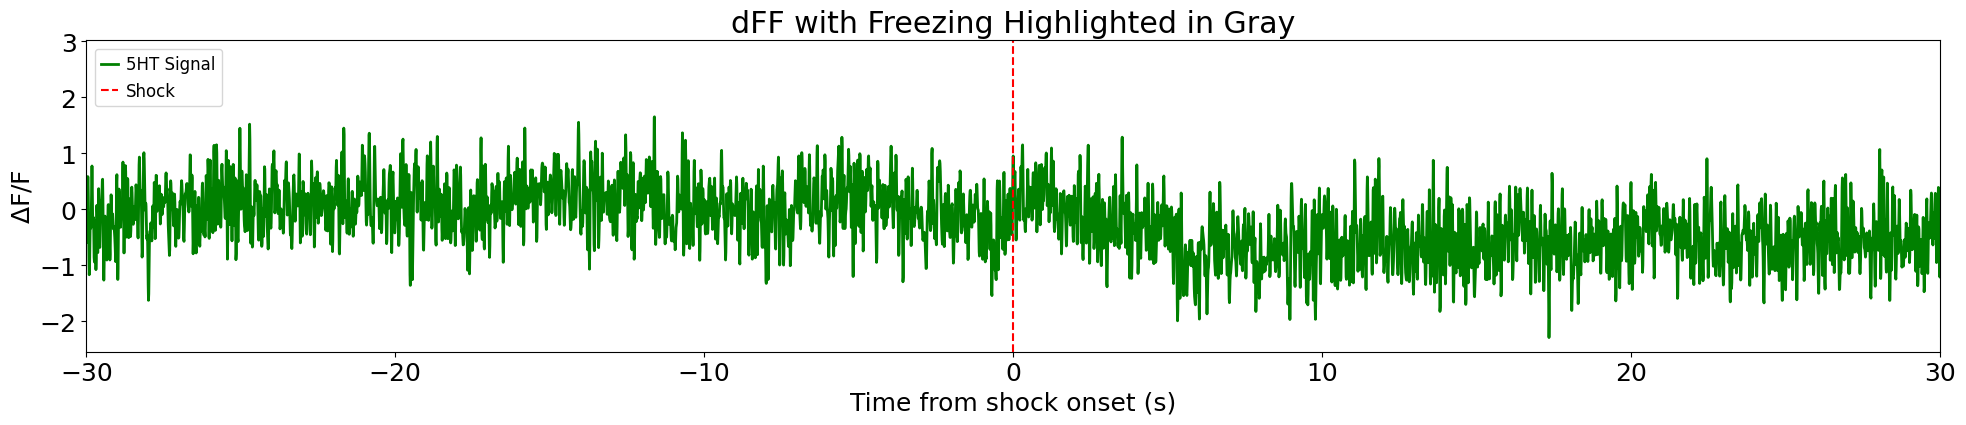

In [26]:
# Final dFF plot with freezing highlights
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311) 

# Plot dFF
p1, = ax2.plot(fiber_time2use_binned, dFF, linewidth=2, color='green', label='5HT Signal')

# Add freezing highlights using the same subplot configuration
ax2.fill_between(   Motion_frameArr_TS_Onset, 
                    ax2.get_ylim()[0],  # Use the natural y-limits from the dFF plot
                    ax2.get_ylim()[1],
                    where=Freezing>0, 
                    color='gray', 
                    alpha=0.3
                )

# Add shock line and formatting - keeping everything identical to original
ax2.set_xlim(xLims)
Plotter.create_ShockLine(ax2)
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Time from shock onset (s)')
ax2.set_title('dFF with Freezing Highlighted in Gray')
ax2.legend(fontsize=12, markerscale=0.8, handlelength=1, handletextpad=0.5, labelspacing=0.5, loc='upper left')
fig3.tight_layout()

In [ ]:
# SAVING THE DATA
# Get mouse_id first from the current directory
mouse_id = os.path.basename(os.getcwd())  # This gets the original folder name like nia_10_5HT_cxtA_day_2

# Create analyzed_data folder if it doesn't exist
output_dir = "analyzed_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Store current directory
current_dir = os.getcwd()

# Save plots directly to output_dir 
fig3.savefig(os.path.join(output_dir, 'fiber_freezing_plot.png'), dpi=300, bbox_inches='tight')
hv.save(plt_fz * plt_mt * threshold_line * shock_line, os.path.join(output_dir, 'motion_freezing_plot.png'))

# Change to output directory before saving data
os.chdir(output_dir)

# Save data files using the original mouse_id
fz.SaveShockDelay(mouse_id, SHOCK_DELAY)
fz.SaveFiberData(video_dict, dFF, fiber_time2use_binned, Freezing, Motion_frameArr_TS_Onset, time_window=xLims)
fz.SaveData(video_dict, Motion, Freezing, mt_cutoff, FreezeThresh, MinDuration)

# Change back to original directory
os.chdir(current_dir)